# Q3: What are the dynamics of snowmelt and albedo?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import seaborn as sns

In [3]:
tram_data = pd.read_csv("../data/tram_complete.csv")
tram_data['date'] = pd.to_datetime(tram_data['date'], format='%Y-%m-%d')
tram_data.drop(columns=['Unnamed: 0'], inplace=True)

In [4]:
tram_data.columns

Index(['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second', 'DD_AKST',
       'DD_Expected_AKST', 'Offset_time', 'DD_UTC', 'Run_number',
       'Stop_number', 'Height', 'ShortW_inc', 'ShortW_out', 'Albedo',
       'LongW_inc', 'LongW_out', 'Net_shortW', 'Net_longW', 'Net_Rad',
       'Sol_Irr_inc', 'Sol_Irr_out', 'PAR_inc', 'PAR_out', 'fPAR', 'Red_i',
       'NIR_i', 'Red_r', 'NIR_r', 'NDVI', 'T_air_C', 'T_surf_C', 'date',
       'Polygon_type', 'Topo_feature'],
      dtype='object')

In [5]:
tram_data.head()

,Year,Month,Day,Hour,Minute,Second,DD_AKST,DD_Expected_AKST,Offset_time,DD_UTC,...,Red_i,NIR_i,Red_r,NIR_r,NDVI,T_air_C,T_surf_C,date,Polygon_type,Topo_feature
0,2014,5,28,5,1,31,148.20939,148.20833,0.025278,148.58439,...,-51.557,-88.863,-1.519,-2.616,-0.119,-6.138,-6.169,2014-05-28,LCP,center
1,2014,5,28,8,1,31,148.33439,148.33333,0.025278,148.70939,...,-204.277,-344.720,-6.234,-10.531,-0.118,-5.934,-5.000,2014-05-28,LCP,center
2,2014,5,28,11,1,30,148.45937,148.45833,0.025000,148.83437,...,-430.776,-740.186,-13.618,-23.447,-0.118,-5.299,-3.226,2014-05-28,LCP,center
3,2014,5,28,14,1,30,148.58437,148.58333,0.025000,148.95937,...,-446.671,-762.150,-14.021,-23.953,-0.118,-5.524,-3.460,2014-05-28,LCP,center
4,2014,5,28,17,1,30,148.70937,148.70833,0.025000,149.08437,...,-349.003,-599.596,-11.268,-19.418,-0.117,-5.764,-4.103,2014-05-28,LCP,center


In [6]:
stop_metadata = pd.read_csv("../data/stop_metadata.csv")
stop_metadata.drop(columns=["Unnamed: 6", "Unnamed: 7"], inplace=True)
stop_metadata.drop(index=[0], inplace=True)
stop_metadata.reset_index(drop=True, inplace=True)
stop_metadata.rename(columns={"Position_for_Measurement": "Stop_number", "Polygon_Type_Feature_ID":"haruko_label"}, inplace=True)

In [7]:
stop_metadata.head()

,Stop_number,Distance_along_Tram,Elevation_of_Position,haruko_label,Polygon_Type,Polygon_Feature
0,1.0,0.0,5.355796,4.0,LCP,center
1,2.0,0.5,5.341441,4.0,LCP,center
2,3.0,1.0,5.302416,4.0,LCP,center
3,4.0,1.5,5.283668,4.0,LCP,center
4,5.0,2.0,5.282776,4.0,LCP,center


In [8]:
tram_data = tram_data.merge(stop_metadata[['Stop_number', 'haruko_label']], how='left', on='Stop_number')

In [9]:
tram_2014 = tram_data[tram_data['date'].dt.year == 2014]

## Comparing date of snowmelt for polygon types and features

In [10]:
tram_data.groupby(by='haruko_label').size()

haruko_label
1.0     2979
2.0    41494
4.0    29507
5.0    13366
7.0     8938
8.0    40199
dtype: int64

### Albedo and snowmelt dynamics

In [11]:
albedo_summary_stats = tram_data.groupby('haruko_label')['Albedo'].agg(['mean', 'min', 'max']).reset_index()
albedo_summary_stats[['mean', 'min', 'max']]
print(albedo_summary_stats)

   haruko_label      mean    min    max
0           1.0  0.331263  0.029  0.910
1           2.0  0.313779  0.010  0.948
2           4.0  0.315764  0.010  0.950
3           5.0  0.321587  0.015  0.947
4           7.0  0.323691  0.015  0.927
5           8.0  0.318555  0.024  0.949


In [12]:
# Define spring transition dates for each year
spring_transitions = {
    2014: ('2014-05-30', '2014-06-25'),
    2016: ('2016-05-10', '2016-06-03'),
    2017: ('2017-05-26', '2017-06-20')
}

# Initialize a list to store results
albedo_change_rates = []

# Iterate over each year and its date range
for year, (start_date, end_date) in spring_transitions.items():
    # Filter data for the year and date range
    year_data = tram_data[
        (tram_data['date'] >= start_date) & 
        (tram_data['date'] <= end_date) & 
        (tram_data['date'].dt.year == year)
    ]
    
    # Group by haruko_label
    for label, group in year_data.groupby('haruko_label'):
        if 'Albedo' in group.columns:  
            # Calculate highest and lowest albedo
            max_albedo = group['Albedo'].max()
            min_albedo = group['Albedo'].min()
            
            # Calculate the number of days in the range
            num_days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days
            
            # Calculate the rate of albedo change
            rate = (max_albedo - min_albedo) / num_days
            
            # Append the result
            albedo_change_rates.append({
                'year': year,
                'haruko_label': label,
                'rate_of_albedo_change': rate
            })

# Convert results to a DataFrame for better visualization
albedo_change_rates_df = pd.DataFrame(albedo_change_rates)

# Display the results
albedo_change_rates_df

,year,haruko_label,rate_of_albedo_change
0,2014,1.0,0.028962
1,2014,2.0,0.030615
2,2014,4.0,0.031500
3,2014,5.0,0.031923
4,2014,7.0,0.028846
5,2014,8.0,0.029308
6,2016,1.0,0.026042
7,2016,2.0,0.032458
8,2016,4.0,0.035958
9,2016,5.0,0.032500


In [13]:
# Initialize a dictionary to store the first thawing date for each year and haruko_label
first_thawing_dates = []

# Iterate over each year and its date range
for year, (start_date, end_date) in spring_transitions.items():
    # Filter data for the year and date range
    year_data = tram_data[
        (tram_data['date'] >= start_date) & 
        (tram_data['date'] <= end_date) & 
        (tram_data['date'].dt.year == year)
    ]
    
    # Group by haruko_label
    for label, group in year_data.groupby('haruko_label'):
        if 'Albedo' in group.columns:  # Ensure albedo column exists
            # Find the date of minimum albedo
            min_albedo_date = group.loc[group['Albedo'].idxmin(), 'date']
            
            # Append the result
            first_thawing_dates.append({
                'year': year,
                'haruko_label': label,
                'min_albedo_date': min_albedo_date
            })

# Convert results to a DataFrame for better visualization
first_thawing_dates_df = pd.DataFrame(first_thawing_dates)

# Sort the DataFrame by year and min_albedo_date to get the thawing order
thawing_order = first_thawing_dates_df.sort_values(by=['year', 'min_albedo_date'])

# Display the thawing order for each year
for year, group in thawing_order.groupby('year'):
    print(f"\nYear {year}:")
    for _, row in group.iterrows():
        print(f"Topo feature {row['haruko_label']} was snow-free on {row['min_albedo_date']}")


Year 2014:
Topo feature 2.0 thawed on 2014-06-16 00:00:00
Topo feature 5.0 thawed on 2014-06-16 00:00:00
Topo feature 1.0 thawed on 2014-06-18 00:00:00
Topo feature 7.0 thawed on 2014-06-18 00:00:00
Topo feature 8.0 thawed on 2014-06-18 00:00:00
Topo feature 4.0 thawed on 2014-06-25 00:00:00

Year 2016:
Topo feature 8.0 thawed on 2016-05-25 00:00:00
Topo feature 2.0 thawed on 2016-05-27 00:00:00
Topo feature 5.0 thawed on 2016-05-27 00:00:00
Topo feature 1.0 thawed on 2016-06-03 00:00:00
Topo feature 4.0 thawed on 2016-06-03 00:00:00
Topo feature 7.0 thawed on 2016-06-03 00:00:00

Year 2017:
Topo feature 1.0 thawed on 2017-06-20 00:00:00
Topo feature 2.0 thawed on 2017-06-20 00:00:00
Topo feature 4.0 thawed on 2017-06-20 00:00:00
Topo feature 5.0 thawed on 2017-06-20 00:00:00
Topo feature 7.0 thawed on 2017-06-20 00:00:00
Topo feature 8.0 thawed on 2017-06-20 00:00:00


In [14]:
polygon_types = {
    1: 'Trough & LCP',
    2: 'Trough & FCP',
    3: 'Trough & HCP',
    4: 'Center & LCP',
    5: 'Center & FCP',
    7: 'High & LCP',
    8: 'High & FCP',
    9: 'High & HCP'
}

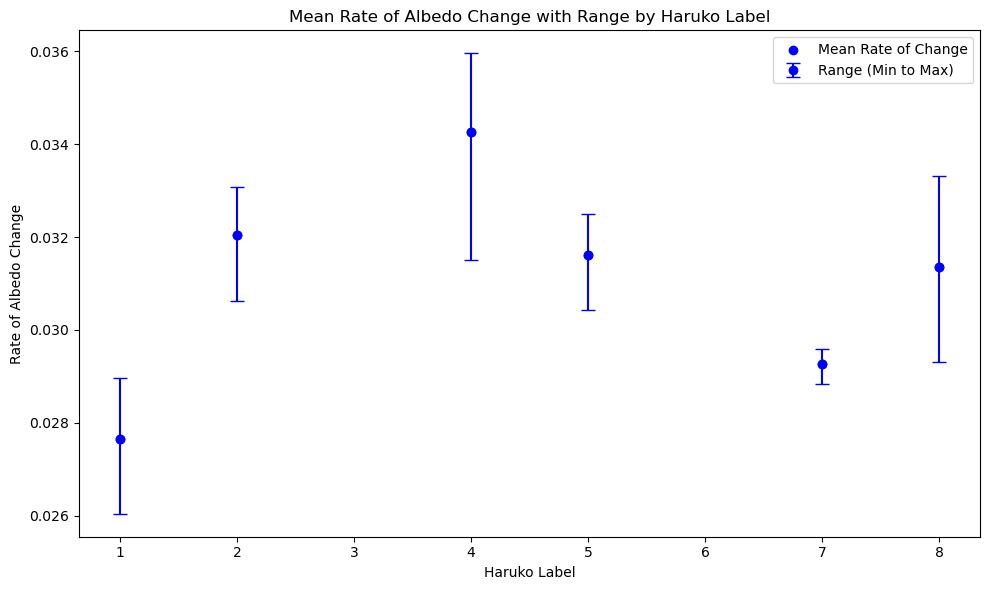

In [15]:
# Calculate median, min, and max rate of albedo change for each haruko_label
albedo_summary = albedo_change_rates_df.groupby('haruko_label')['rate_of_albedo_change'].agg(['mean', 'min', 'max']).reset_index()

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot for median values
ax.scatter(albedo_summary['haruko_label'], albedo_summary['mean'], color='blue', label='Mean Rate of Change')

# Add error bars for range (min to max)
ax.errorbar(
    albedo_summary['haruko_label'],
    albedo_summary['mean'],
    yerr=[albedo_summary['mean'] - albedo_summary['min'], albedo_summary['max'] - albedo_summary['mean']],
    fmt='o',
    color='blue',
    capsize=5,
    label='Range (Min to Max)'
)

# Add labels and title
ax.set_xlabel('Haruko Label')
ax.set_ylabel('Rate of Albedo Change')
ax.set_title('Mean Rate of Albedo Change with Range by Haruko Label')
ax.legend()

# Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()

# Plotting Seasonality of Albedo

In [16]:
def plot_tram_data(year):
    tram_year = tram_data[tram_data['Year'] == year]

    daily_avg = tram_year.groupby(["date", "Stop_number"]).agg({
         "NDVI": "mean",
         "Albedo": "mean",
    }).reset_index()

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10), sharex=True)

    sns.lineplot(ax=axes[0], data=daily_avg, x="date", y="NDVI", hue="Stop_number", palette="coolwarm", alpha=0.5)
    axes[0].set_title("Avg. NDVI per Stop")
    axes[0].legend([],[], frameon=False)

    sns.lineplot(ax=axes[1], data=daily_avg, x="date", y="Albedo", hue="Stop_number", palette="coolwarm", alpha=0.5)
    axes[1].set_title(f"{year} Avg. Albedo per Stop")
    axes[1].legend([],[], frameon=False)

    # Set x-axis ticks to show every day
    date_range = pd.date_range(start=daily_avg['date'].min(), end=daily_avg['date'].max())
    plt.xticks(date_range, date_range.strftime('%Y-%m-%d'), rotation=90)

    plt.tight_layout()
    plt.show()


In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.patches import Patch

def plot_tram_data(year):
    tram_year = tram_data[tram_data['Year'] == year]

    # Group by date and Stop_number
    daily_avg = tram_year.groupby(["date", "Stop_number"]).agg({
         "NDVI": "mean",
         "Albedo": "mean",
         "haruko_label": "first"  # assuming haruko_label is constant within a Stop_number
    }).reset_index()

    # Create an HLS color palette for unique haruko_label values
    unique_labels = sorted(daily_avg["haruko_label"].unique())
    palette = sns.color_palette("hls", len(unique_labels))
    label_color_map = dict(zip(unique_labels, palette))

    # Map the colors to each row
    daily_avg["color"] = daily_avg["haruko_label"].map(label_color_map)

    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(20, 10), sharex=True)

    # Plot NDVI
    for stop in daily_avg["Stop_number"].unique():
        stop_data = daily_avg[daily_avg["Stop_number"] == stop]
        axes[0].plot(stop_data["date"], stop_data["NDVI"], color=stop_data["color"].iloc[0], alpha=0.5)

    axes[0].set_title("Avg. NDVI per Stop")

    # Plot Albedo
    for stop in daily_avg["Stop_number"].unique():
        stop_data = daily_avg[daily_avg["Stop_number"] == stop]
        axes[1].plot(stop_data["date"], stop_data["Albedo"], color=stop_data["color"].iloc[0], alpha=0.5)

    axes[1].set_title(f"{year} Avg. Albedo per Stop")

    # Create a custom legend for haruko_label
    legend_elements = [Patch(facecolor=label_color_map[label], label=str(label)) for label in unique_labels]
    axes[1].legend(handles=legend_elements, title="haruko_label", bbox_to_anchor=(1.01, 1), loc="upper left")

    # Set x-axis ticks to show every day
    date_range = pd.date_range(start=daily_avg['date'].min(), end=daily_avg['date'].max())
    plt.xticks(date_range, date_range.strftime('%Y-%m-%d'), rotation=90)

    plt.tight_layout()
    plt.show()


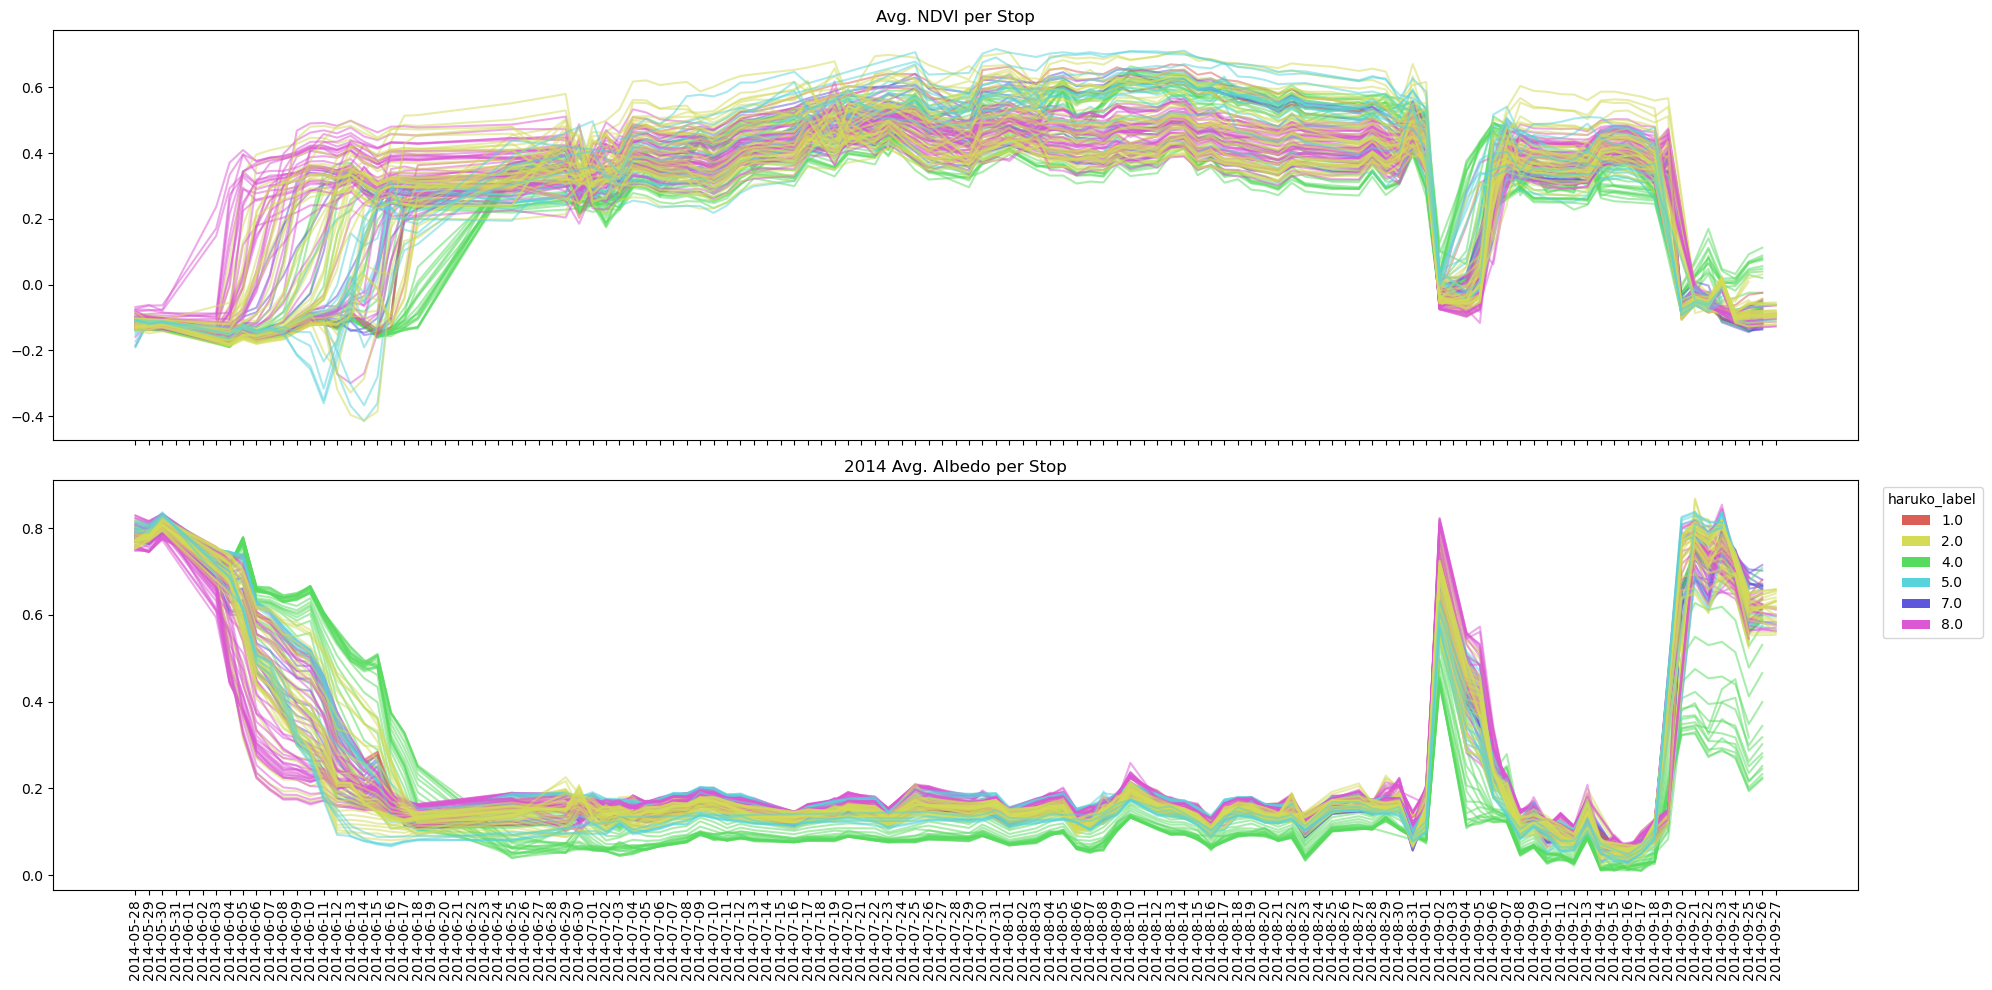

In [18]:
plot_tram_data(2014)

polygon_types = {
    1: 'Trough & LCP',
    2: 'Trough & FCP',
    3: 'Trough & HCP',
    4: 'Center & LCP',
    5: 'Center & FCP',
    7: 'High & LCP',
    8: 'High & FCP',
    9: 'High & HCP'
}

### FCP High, haruko_label = 8 2014

In [19]:
daily_8_tram = tram_2014[tram_2014['haruko_label'] == 8].groupby('date').agg({
    'NDVI': 'mean',
    'Albedo': 'mean'
}).reset_index()

print(daily_8_tram[ (daily_8_tram['date'] == '2014-05-30') | (daily_8_tram['date'] == '2014-06-03')| (daily_8_tram['date'] == '2014-06-06') | (daily_8_tram['date'] == '2014-07-25')] )

         date      NDVI    Albedo
2  2014-05-30 -0.109130  0.799445
3  2014-06-03 -0.110886  0.688229
6  2014-06-06  0.081525  0.397750
41 2014-07-25  0.480008  0.183825


In [20]:

# calculated in q2 file
avg_snow_albedo_8_2014 = 0.782909
avg_no_snow_albedo_8_2014 = 0.161717

# Defining albedo values for calculations
total_albedo_change_8_2014 = avg_snow_albedo_8_2014 - avg_no_snow_albedo_8_2014
print(f"Total Albedo Change: {total_albedo_change_8_2014}")

# transition start and end dates
albedo_8_05_30 = daily_8_tram[daily_8_tram['date'] == '2014-05-30']['Albedo'].values[0]
albedo_8_07_25 = daily_8_tram[daily_8_tram['date'] == '2014-07-25']['Albedo'].values[0]

# end days of large transition for harkuo 8
albedo_8_06_03 = daily_8_tram[daily_8_tram['date'] == '2014-06-03']['Albedo'].values[0]
albedo_8_06_06 = daily_8_tram[daily_8_tram['date'] == '2014-06-06']['Albedo'].values[0]


Total Albedo Change: 0.621192


In [21]:
largest_albedo_change_8 = albedo_8_05_30 - albedo_8_06_06
largest_percent_change_8 = (largest_albedo_change_8 / (albedo_8_05_30 - albedo_8_07_25)) * 100
print(f"Largest Albedo Change from 05-30 to 06-06: {largest_percent_change_8}")

Largest Albedo Change from 05-30 to 06-06: 65.25047919170918


In [22]:
import seaborn as sns

def plot_albedo_transition_by_haruko_label(tram_data, year):
    import matplotlib.pyplot as plt

    # Filter data for the spring transition period
    if year == 2014:
        tram_year = tram_data[(tram_data['Year'] == year) & 
                              (tram_data['date'] <= f'{year}-06-18') & 
                              (tram_data['date'] >= f'{year}-06-01')]
    elif year == 2016:
        tram_year = tram_data[(tram_data['Year'] == year) & 
                              (tram_data['date'] <= f'{year}-06-05') & 
                              (tram_data['date'] >= f'{year}-05-09')]
    elif year == 2017:
        tram_year = tram_data[(tram_data['Year'] == year) & 
                              (tram_data['date'] <= f'{year}-06-22') & 
                              (tram_data['date'] >= f'{year}-05-25')]
    else:
        print(f"No filter rules for year {year}")
        return

    # Aggregate daily mean albedo by polygon type
    tram_transition_daily = tram_year.groupby(['date', 'haruko_label']).agg({
        'Albedo': 'mean'
    }).reset_index()

    # Map haruko_label to polygon type names
    tram_transition_daily['Polygon Type'] = tram_transition_daily['haruko_label'].map(polygon_types)

    # Set up the plot style
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(15, 5))
    # palette = sns.color_palette("viridis", len(tram_transition_daily['Polygon Type'].unique()))

    viridis = plt.cm.get_cmap("viridis", 256)
    color_positions = [0.0, 0.15, 0.35, 0.45, 0.8, 0.9, 1.0]  # skip the teal region
    palette = [viridis(p) for p in color_positions[:len(tram_transition_daily['Polygon Type'].unique())]]
    palette = [
        "#FDE725",  # yellow
        "#ed6925",  # orange
        "#B7312C",   # red
        "#4AC16D",  # green
        "#3B528B",  # blue
        "#440154",  # purple       
        
    ][:len(tram_transition_daily['Polygon Type'].unique())]



    # Plot
    sns.lineplot(
        data=tram_transition_daily,
        x='date',
        y='Albedo',
        hue='Polygon Type',
        palette=palette,
        linewidth=2.5,
        marker='o'
    )

    plt.title(f'Daily Albedo in {year} (Spring Transition)', fontsize=18, weight='bold')
    plt.xlabel('Date', fontsize=16)
    plt.ylabel('Mean Albedo', fontsize=16)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=12)
    plt.legend(title='Polygon Type', fontsize=14, title_fontsize=15, loc='upper right', frameon=False)
    plt.tight_layout()
    plt.show()


/var/folders/9p/2rqd7rmn3jbfmz4v57p0_0300000gp/T/ipykernel_46580/1648981688.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap("viridis", 256)


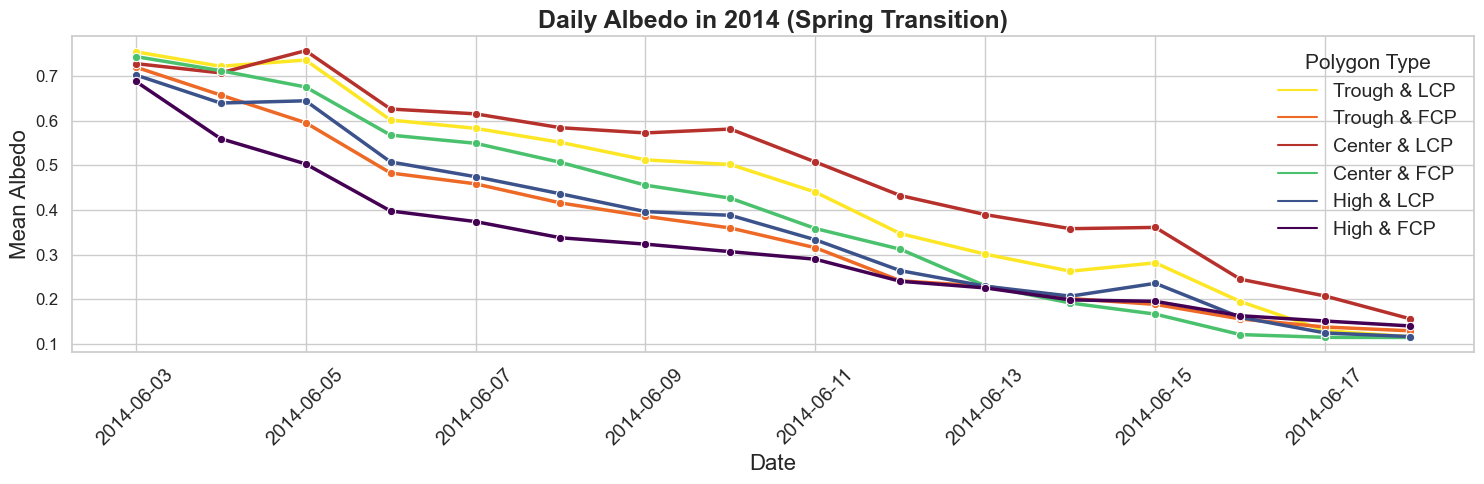

In [23]:
plot_albedo_transition_by_haruko_label(tram_data, 2014)

/var/folders/9p/2rqd7rmn3jbfmz4v57p0_0300000gp/T/ipykernel_46580/1648981688.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap("viridis", 256)


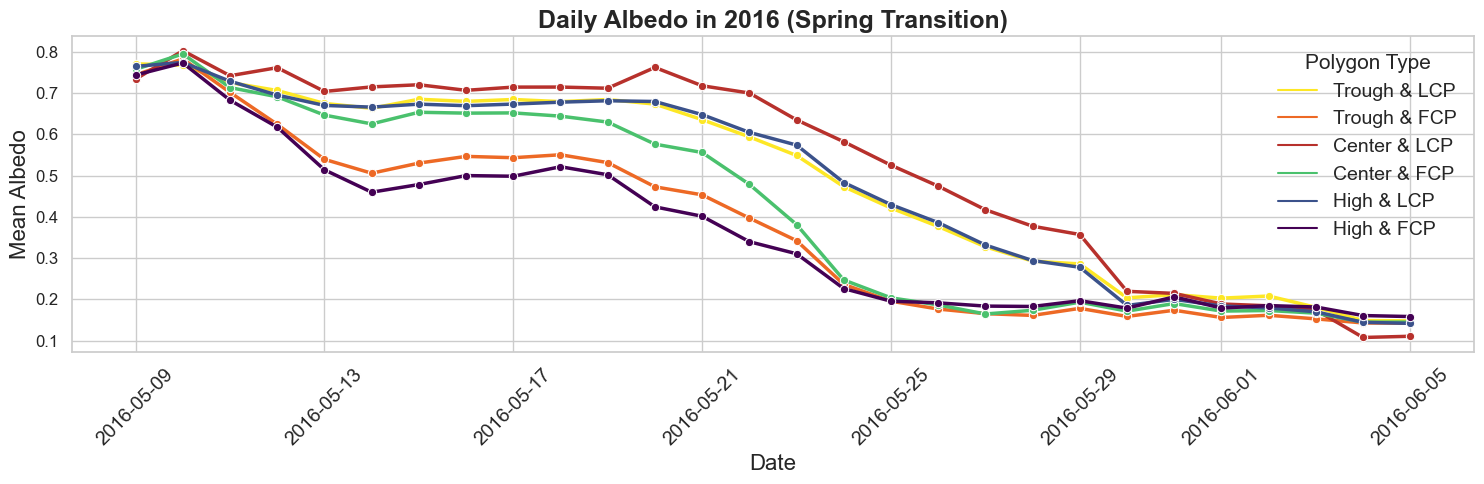

In [24]:
plot_albedo_transition_by_haruko_label(tram_data, 2016)

/var/folders/9p/2rqd7rmn3jbfmz4v57p0_0300000gp/T/ipykernel_46580/1648981688.py:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  viridis = plt.cm.get_cmap("viridis", 256)


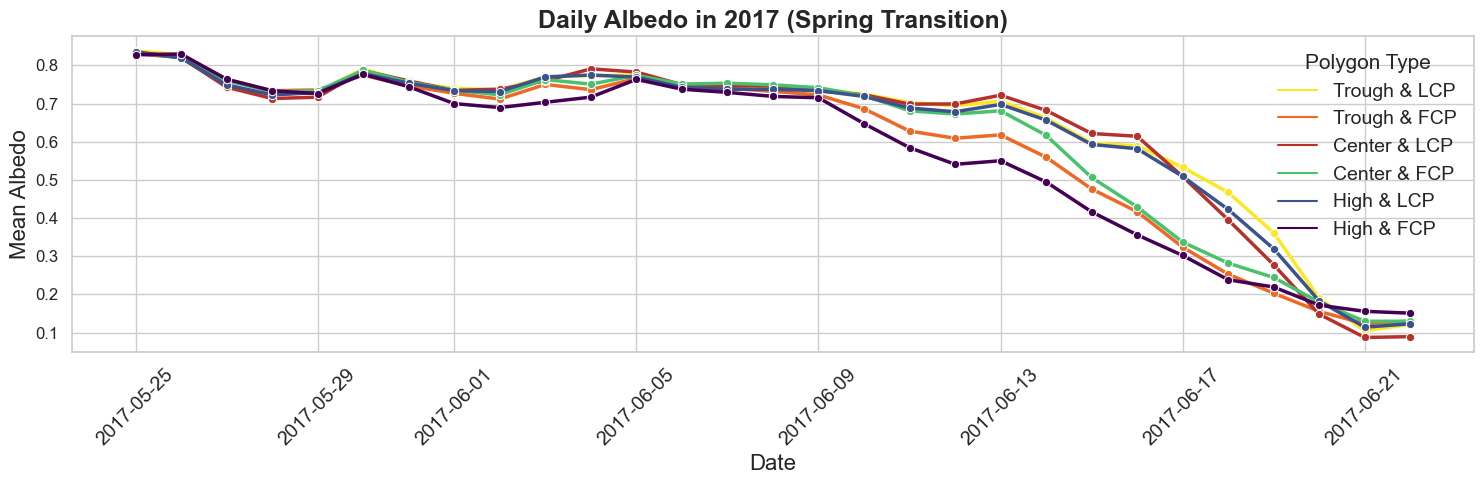

In [25]:
plot_albedo_transition_by_haruko_label(tram_data, 2017)

In [49]:
from matplotlib.dates import DateFormatter, AutoDateLocator
import matplotlib.cm as cm
import matplotlib.colors as mcolors

def plot_tram_data_by_label(year):
    # Filter data for the specified year
    if year == 2014:
        tram_year = tram_data[
            (tram_data['Year'] == year) & 
            (tram_data['date'] <= f'{year}-06-18') & 
            (tram_data['date'] >= f'{year}-06-01')
        ]
    elif year == 2016:
        tram_year = tram_data[
            (tram_data['Year'] == year) & 
            (tram_data['date'] <= f'{year}-06-05') & 
            (tram_data['date'] >= f'{year}-05-09')
        ]
    elif year == 2017:
        tram_year = tram_data[
            (tram_data['Year'] == year) & 
            (tram_data['date'] <= f'{year}-06-22') & 
            (tram_data['date'] >= f'{year}-05-25')
        ]
    else:
        print(f"No filter rules for year {year}")
        return

    # Get unique haruko_labels
    tram_year = tram_year[(tram_year['haruko_label'] == 4.0) | (tram_year['haruko_label'] == 8.0)]
    unique_labels = sorted(tram_year['haruko_label'].unique())

    # Create subplots
    fig, axes = plt.subplots(
        nrows=len(unique_labels), ncols=1,
        figsize=(8, 3 * len(unique_labels)), dpi=200, sharex=True
    )

    if len(unique_labels) == 1:
        axes = [axes]  # Ensure axes is iterable

    # Create full date range for consistent x-axis
    full_dates = pd.date_range(start=tram_year['date'].min(), end=tram_year['date'].max())

    for i, label in enumerate(unique_labels):
        label_data = tram_year[tram_year['haruko_label'] == label]

        # Group by date and stop
        daily_avg = label_data.groupby(["date", "Stop_number"]).agg({
            "Albedo": "mean"
        }).reset_index()

        unique_stops = sorted(daily_avg["Stop_number"].unique())

         # Define a fixed color for each haruko_label
        cmap = cm.get_cmap('viridis')
        color_map = {
            4.0: cmap(0.8),  # a greenish shade
            8.0: cmap(0.3),  # a purple-ish shade
        }

        line_color = color_map.get(label, 'grey')

        for stop in unique_stops:
            stop_data = daily_avg[daily_avg["Stop_number"] == stop].set_index('date').reindex(full_dates)
            stop_data['Stop_number'] = stop
            axes[i].plot(
                full_dates,
                stop_data["Albedo"],
                color=line_color,
                linewidth=0.5,
                alpha=0.5,
                label=f"Stop {int(stop)}" if stop == unique_stops[0] else ""
            )

        # Plot mean Albedo
        mean_albedo = daily_avg.groupby('date')['Albedo'].mean().reindex(full_dates)
        axes[i].plot(full_dates, mean_albedo, color='black', linewidth=3, label="Mean Albedo")

        polygon_type = polygon_types.get(int(label), "Unknown")
        axes[i].set_title(f"Albedo for {polygon_type} ({year})")
        axes[i].set_ylabel("Albedo")

    # Format x-axis ticks
    axes[-1].xaxis.set_major_locator(AutoDateLocator())
    axes[-1].xaxis.set_major_formatter(DateFormatter('%Y-%m-%d'))
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


/var/folders/9p/2rqd7rmn3jbfmz4v57p0_0300000gp/T/ipykernel_46580/3045846890.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')
/var/folders/9p/2rqd7rmn3jbfmz4v57p0_0300000gp/T/ipykernel_46580/3045846890.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


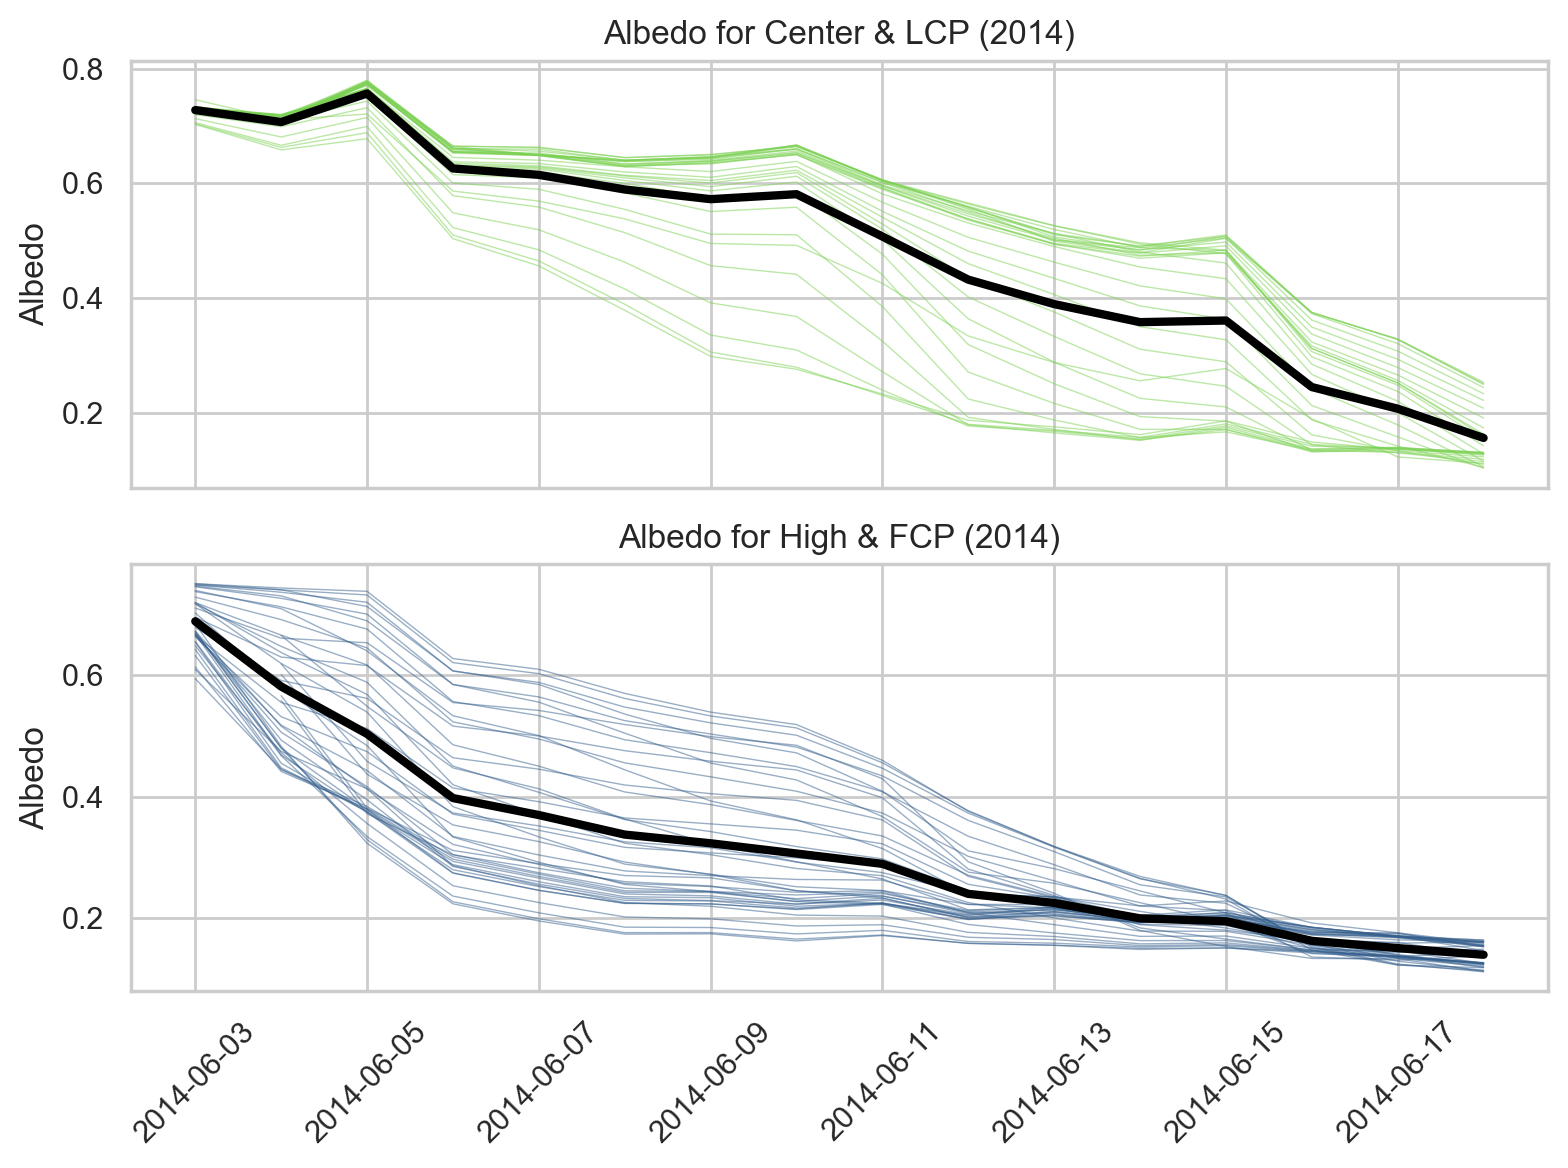

In [50]:
plot_tram_data_by_label(2014)

/var/folders/9p/2rqd7rmn3jbfmz4v57p0_0300000gp/T/ipykernel_46580/3045846890.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')
/var/folders/9p/2rqd7rmn3jbfmz4v57p0_0300000gp/T/ipykernel_46580/3045846890.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


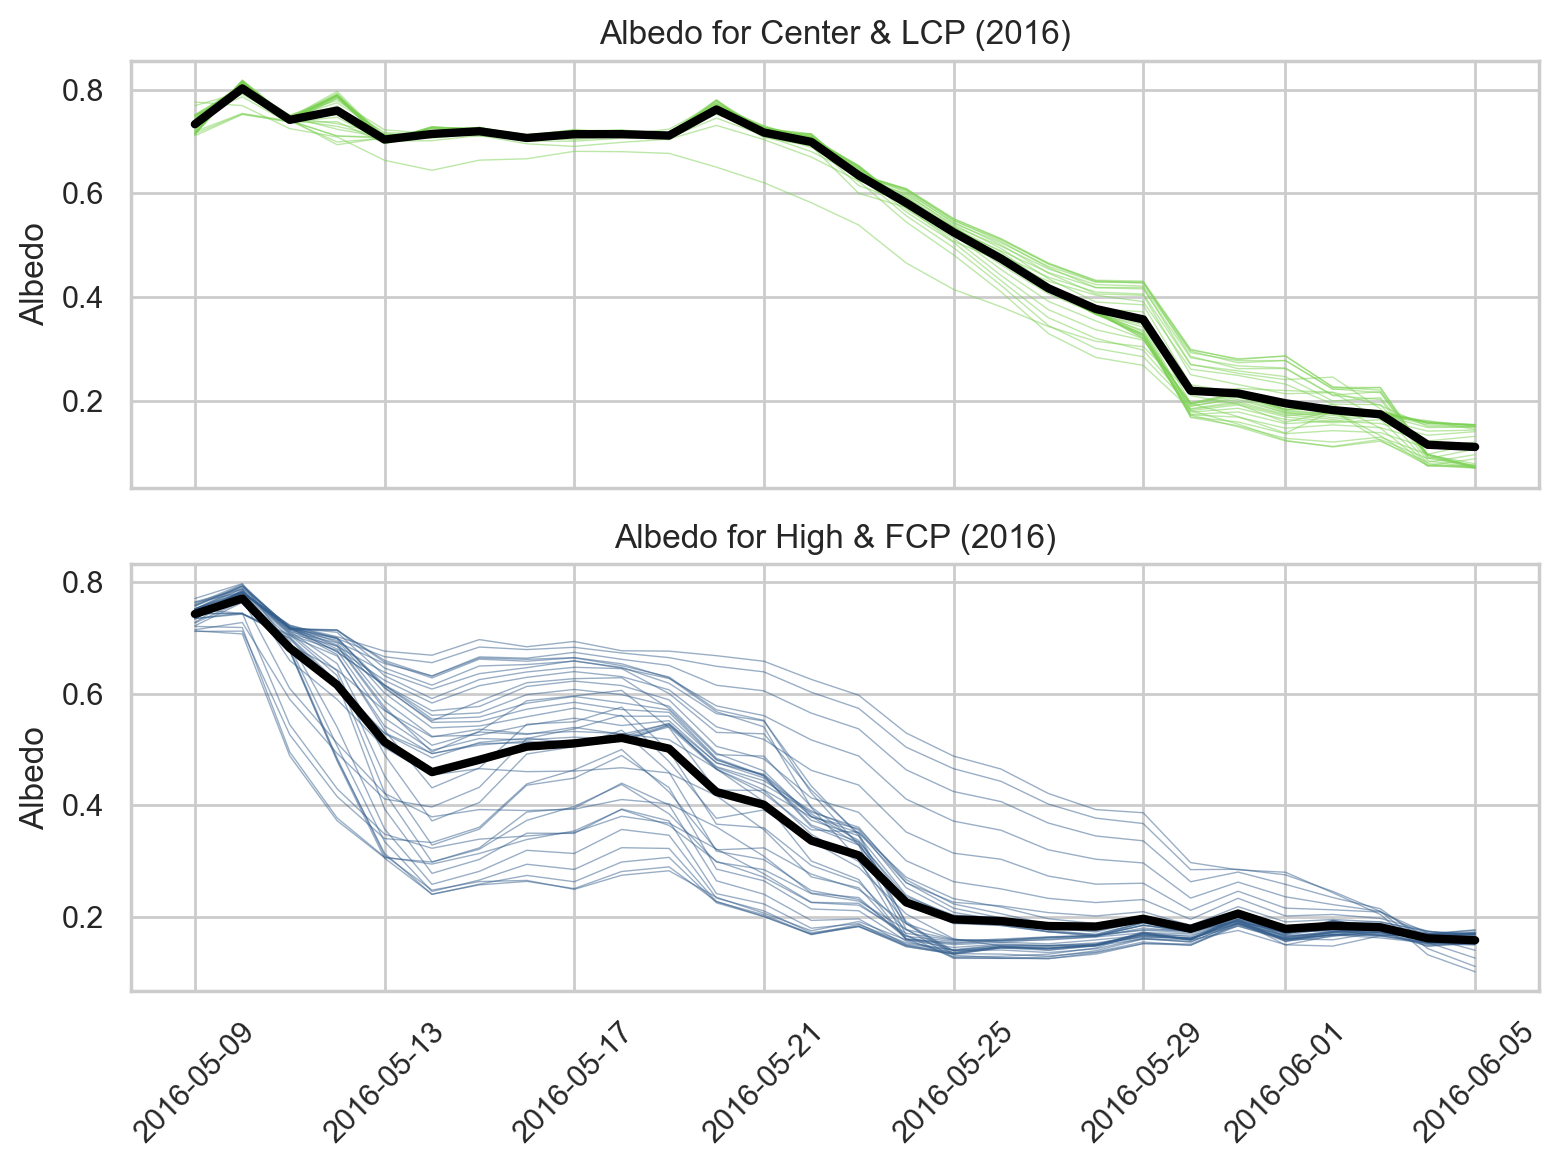

In [51]:
plot_tram_data_by_label(2016)

/var/folders/9p/2rqd7rmn3jbfmz4v57p0_0300000gp/T/ipykernel_46580/3045846890.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')
/var/folders/9p/2rqd7rmn3jbfmz4v57p0_0300000gp/T/ipykernel_46580/3045846890.py:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('viridis')


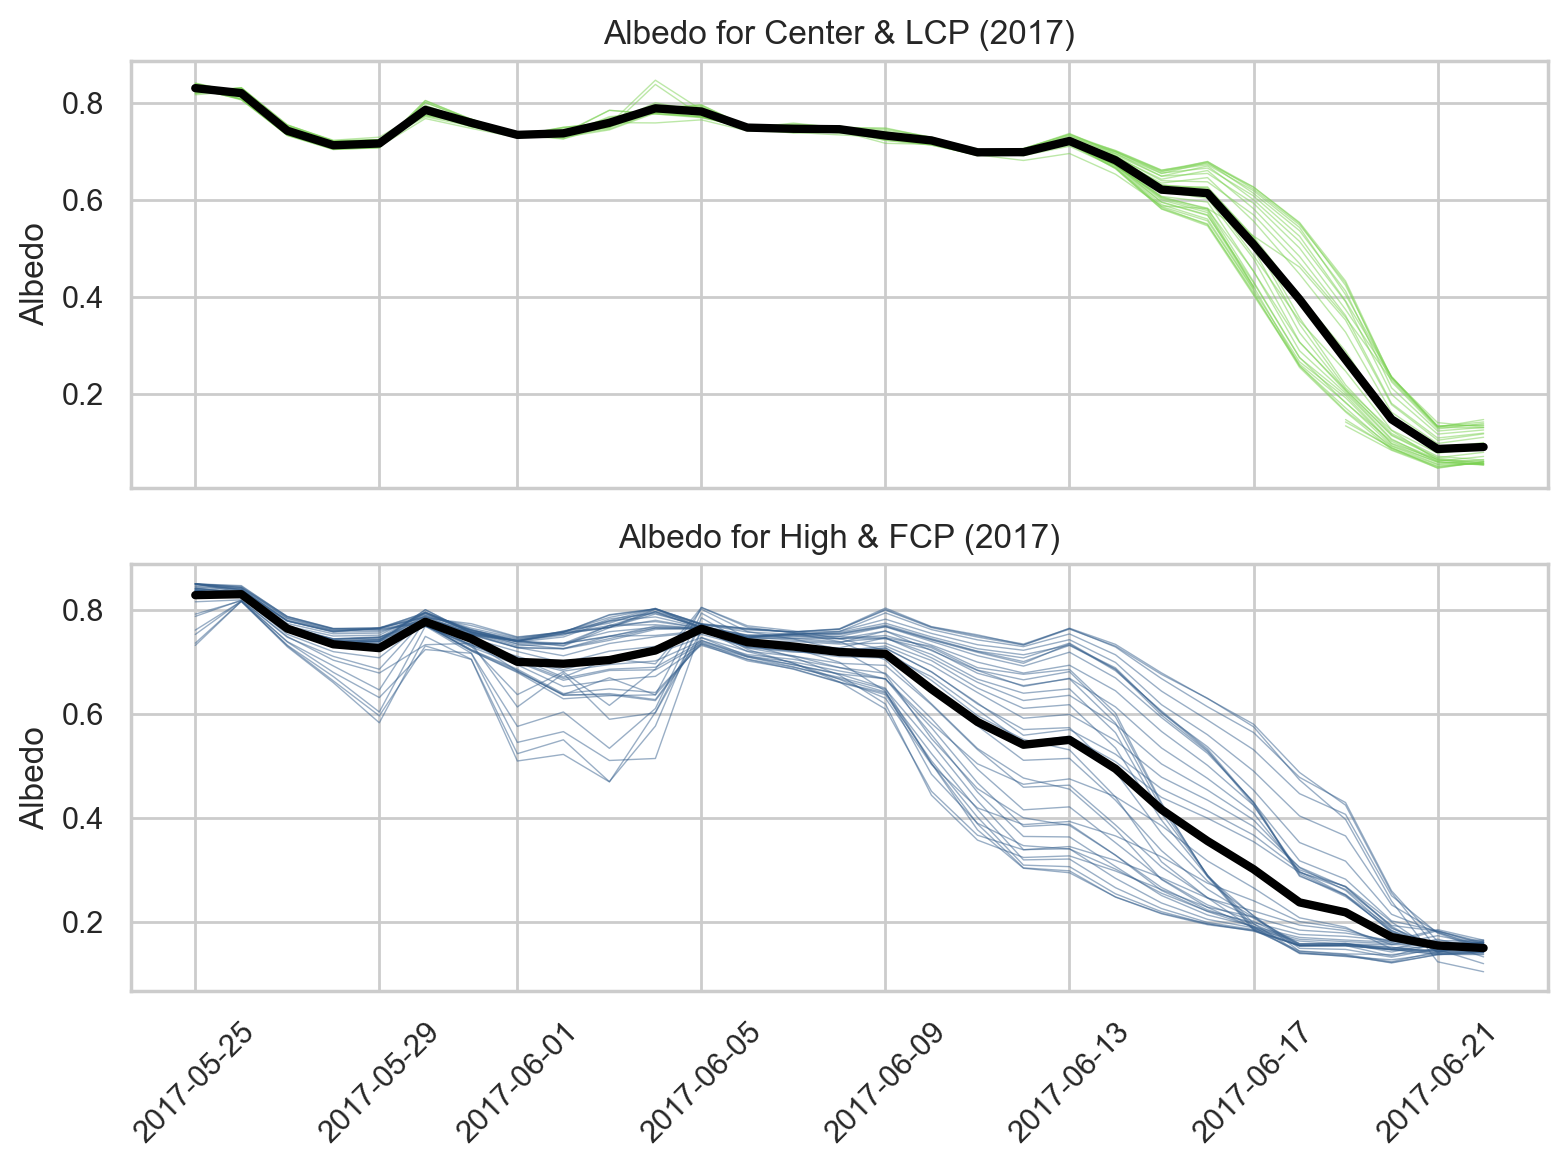

In [52]:
plot_tram_data_by_label(2017)

ConversionError: Failed to convert value(s) to axis units: array(['LCP', 'LCP', 'LCP', ..., 'FCP', 'FCP', 'FCP'], dtype=object)

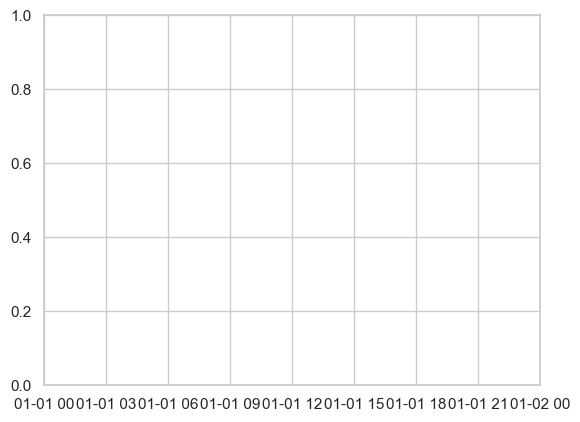

In [32]:

plt.plot(tram_data['date'], tram_data)

In [53]:
tram_data[tram_data['haruko_label'] ==1]['Stop_number'].unique()

array([40, 41, 42])

In [54]:
tram_data.columns

Index(['Year', 'Month', 'Day', 'Hour', 'Minute', 'Second', 'DD_AKST',
       'DD_Expected_AKST', 'Offset_time', 'DD_UTC', 'Run_number',
       'Stop_number', 'Height', 'ShortW_inc', 'ShortW_out', 'Albedo',
       'LongW_inc', 'LongW_out', 'Net_shortW', 'Net_longW', 'Net_Rad',
       'Sol_Irr_inc', 'Sol_Irr_out', 'PAR_inc', 'PAR_out', 'fPAR', 'Red_i',
       'NIR_i', 'Red_r', 'NIR_r', 'NDVI', 'T_air_C', 'T_surf_C', 'date',
       'Polygon_type', 'Topo_feature', 'haruko_label'],
      dtype='object')

In [55]:
print(tram_data[tram_data['date'] == '2016-05-29']['Albedo'].min())
print(tram_data[tram_data['date'] == '2016-05-29']['Albedo'].max())

0.097
0.469


### LCP Center, haruko_label = 4 2014

In [56]:
daily_4_tram = tram_2014[tram_2014['haruko_label'] == 4].groupby('date').agg({
    'NDVI': 'mean',
    'Albedo': 'mean'
}).reset_index()

print(daily_4_tram[ (daily_4_tram['date'] == '2014-05-30') | (daily_4_tram['date'] == '2014-06-03')| (daily_4_tram['date'] == '2014-06-06') | (daily_4_tram['date'] == '2014-07-25')] )

         date      NDVI    Albedo
2  2014-05-30 -0.128267  0.809700
3  2014-06-03 -0.166900  0.727833
6  2014-06-06 -0.158000  0.626089
41 2014-07-25  0.493967  0.117711


In [57]:
# Defining albedo values for calculations
avg_snow_albedo_4_2014 = 0.804731
avg_no_snow_albedo_4_2014 = 0.151726
total_albedo_change_4_2014 = avg_snow_albedo_4_2014 - avg_no_snow_albedo_4_2014
print(f"Total Albedo Change: {total_albedo_change_4_2014}")

# transition start and end dates
albedo_4_05_30 = daily_4_tram[daily_4_tram['date'] == '2014-05-30']['Albedo'].values[0]
albedo_4_07_25 = daily_4_tram[daily_4_tram['date'] == '2014-07-25']['Albedo'].values[0]

# end days of large transition for haruko 8
albedo_4_06_03 = daily_4_tram[daily_4_tram['date'] == '2014-06-03']['Albedo'].values[0]
albedo_4_06_06 = daily_4_tram[daily_4_tram['date'] == '2014-06-06']['Albedo'].values[0]

# start days of large transition for haruko 4
albedo_4_06_10 = daily_4_tram[daily_4_tram['date'] == '2014-06-10']['Albedo'].values[0]
albedo_4_06_11 = daily_4_tram[daily_4_tram['date'] == '2014-06-11']['Albedo'].values[0]

Total Albedo Change: 0.653005


In [58]:
smaller_albedo_change_4 = albedo_4_05_30 - albedo_4_06_06
smaller_percent_change_4 = (smaller_albedo_change_4 / (albedo_4_05_30 - albedo_4_07_25)) * 100
print(f"Largest Albedo Change for Haruko = 8 from 05-30 to 06-06: {smaller_percent_change_4}")

Largest Albedo Change for Haruko = 8 from 05-30 to 06-06: 26.53382360025048


In [59]:
largest_albedo_change_4 = albedo_4_06_11 - albedo_4_07_25
largest_percent_change_4 = (largest_albedo_change_4 / (albedo_4_05_30 - albedo_4_07_25)) * 100
print(f"Largest Albedo Change for Haruko = 8 from 06-11 to 07-25: {largest_percent_change_4}")

Largest Albedo Change for Haruko = 8 from 06-11 to 07-25: 56.314327461905286


### NDVI and snowmelt dynamics

In [60]:
ndvi_summary_stats = tram_data.groupby('haruko_label')['NDVI'].agg(['mean', 'min', 'max']).reset_index()
ndvi_summary_stats[['mean', 'min', 'max']]
print(ndvi_summary_stats)

   haruko_label      mean    min    max
0           1.0  0.283904 -0.199  0.734
1           2.0  0.281669 -0.462  0.856
2           4.0  0.240368 -0.289  0.762
3           5.0  0.300113 -0.623  0.834
4           7.0  0.255789 -0.206  0.777
5           8.0  0.275022 -0.495  0.816


# Change NDVI dates! 

In [61]:
# Define spring transition dates for each year
spring_transitions = {
    2014: ('2014-05-30', '2014-06-25'),
    2016: ('2016-05-10', '2016-06-03'),
    2017: ('2017-05-26', '2017-06-20')
}

# Initialize a list to store results
ndvi_change_rates = []

# Iterate over each year and its date range
for year, (start_date, end_date) in spring_transitions.items():
    # Filter data for the year and date range
    year_data = tram_data[
        (tram_data['date'] >= start_date) & 
        (tram_data['date'] <= end_date) & 
        (tram_data['date'].dt.year == year)
    ]
    
    # Group by haruko_label
    for label, group in year_data.groupby('haruko_label'):
        if 'NDVI' in group.columns:  # Ensure NDVI column exists
            # Calculate highest and lowest NDVI
            max_ndvi = group['NDVI'].max()
            min_ndvi = group['NDVI'].min()
            
            # Calculate the number of days in the range
            num_days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days
            
            # Calculate the rate of NDVI change
            rate = (max_ndvi - min_ndvi) / num_days
            
            # Append the result
            ndvi_change_rates.append({
                'year': year,
                'haruko_label': label,
                'rate_of_ndvi_change': rate
            })

# Convert results to a DataFrame for better visualization
ndvi_change_rates_df = pd.DataFrame(ndvi_change_rates)

# Display the results
ndvi_change_rates_df

,year,haruko_label,rate_of_ndvi_change
0,2014,1.0,0.022346
1,2014,2.0,0.043538
2,2014,4.0,0.023808
3,2014,5.0,0.053462
4,2014,7.0,0.022462
5,2014,8.0,0.045538
6,2016,1.0,0.023333
7,2016,2.0,0.032417
8,2016,4.0,0.024917
9,2016,5.0,0.035958


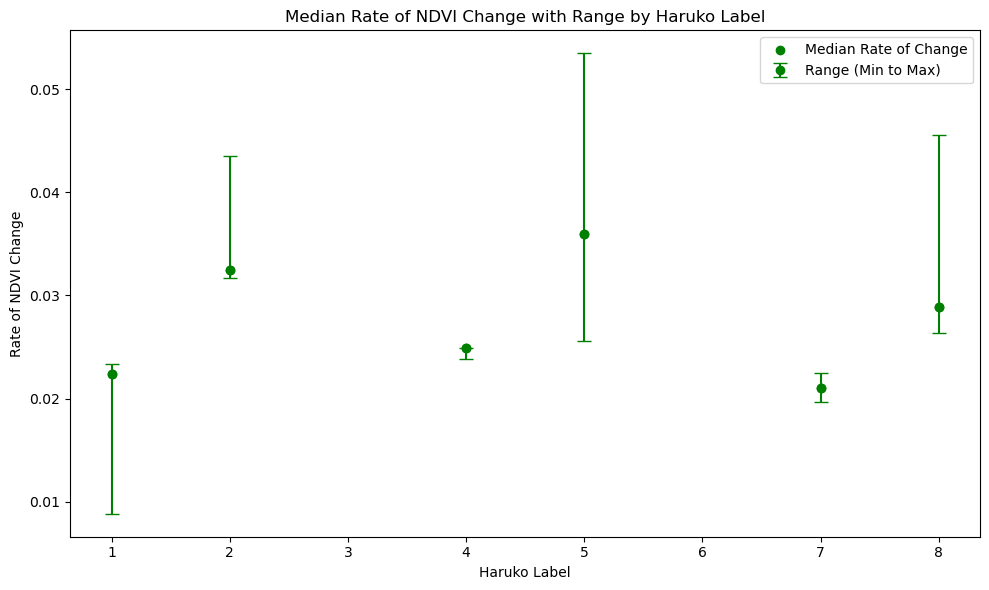

In [62]:
# Calculate median, min, and max rate of NDVI change for each haruko_label
ndvi_summary = ndvi_change_rates_df.groupby('haruko_label')['rate_of_ndvi_change'].agg(['median', 'min', 'max']).reset_index()

# Plot the results
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot for median values
ax.scatter(ndvi_summary['haruko_label'], ndvi_summary['median'], color='green', label='Median Rate of Change')

# Add error bars for range (min to max)
ax.errorbar(
    ndvi_summary['haruko_label'],
    ndvi_summary['median'],
    yerr=[ndvi_summary['median'] - ndvi_summary['min'], ndvi_summary['max'] - ndvi_summary['median']],
    fmt='o',
    color='green',
    capsize=5,
    label='Range (Min to Max)'
)

# Add labels and title
ax.set_xlabel('Haruko Label')
ax.set_ylabel('Rate of NDVI Change')
ax.set_title('Median Rate of NDVI Change with Range by Haruko Label')
ax.legend()

# Rotate x-axis labels for better readability
plt.tight_layout()

# Show the plot
plt.show()